In [32]:
import open3d as o3d
import numpy as np

from Eval.Mesh import CreatePointcloudFromDir
from Eval.Clouds.Sphere import CreateBaseSpherePointCloud
from Eval.Plotting import plot_technique_std
from Eval.Info import SCANNING_TECHNIQUES
from Utils.Format import MilimeterToMeter
from Utils.Data import JSON

In [33]:
# Main Settings

eval = 'Point_E' # Either Kinect, PolyCam or Point_E

assert eval in SCANNING_TECHNIQUES, f'Invalid Evaluation Technique: {eval}'

evalCloudDir = f'../data/{eval}/sphere.ply'

### Distance Compute

In [34]:
baseSphere = CreateBaseSpherePointCloud(diameter = MilimeterToMeter(200), resolution=5000)

collectedSphere = CreatePointcloudFromDir(evalCloudDir)

# Perform Data Adjustment based on know problems with Each technique.
match eval:
    case 'Kinect':
        print("Performing Kinect Data Adjustment")
        collectedSphere = collectedSphere.uniform_down_sample(every_k_points=5)
    
    case 'PolyCam':
        print("Performing PolyCam Data Adjustment")
        collectedSphere = collectedSphere.uniform_down_sample(every_k_points=10)

    case 'Point_E':
        print("Performing Point_E Data Adjustment")

        print("Scaling Point_E Data to Match Meter Units")
        collectedSphere.scale(MilimeterToMeter(200), collectedSphere.get_center())


Performing Point_E Data Adjustment
Scaling Point_E Data to Match Meter Units


In [35]:
# Perform ICP Registration to Obtain a Transformation Matrix
# This allows for more accurate comparison of the clouds, by making them similar positioning.


icpRegResults = o3d.pipelines.registration.registration_icp(collectedSphere, 
                                                            baseSphere, 
                                                            0.1, 
                                                            np.identity(4), 
                                                            o3d.pipelines.registration.TransformationEstimationPointToPoint(), 
                                                            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000))

print(icpRegResults)

# Apply the Transformation Matrix to the Obtained Data Clouds
collectedSphere.transform(icpRegResults.transformation)

RegistrationResult with fitness=1.000000e+00, inlier_rmse=4.095862e-03, and correspondence_set size of 4096
Access transformation to get result.


PointCloud with 4096 points.

### Collect Data

In [36]:
# Get Distance Data
distances = np.array(collectedSphere.compute_point_cloud_distance(baseSphere))

distances *= 1000 # Convert to Milimeters

In [37]:
# Get Standard Graph Data
# Make sure all graphs are the same size

stdJSON = JSON('../data/techniques-std-data.json')

graphStandards = stdJSON.data["STANDARDS"]

del stdJSON

Loaded JSON From: d:\Programming\Projects\Dissertation-2022_2023\Dissertation\notebooks\data\techniques-std-data.json
Saved JSON at: d:\Programming\Projects\Dissertation-2022_2023\Dissertation\notebooks\data\techniques-std-data.json


### Plot Bell Curve

d:\programming\projects\dissertation-2022_2023\dissertation\Eval\Plotting.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(
C:\Users\finnd\AppData\Local\Temp\ipykernel_8848\4028996719.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  stdFig.show()


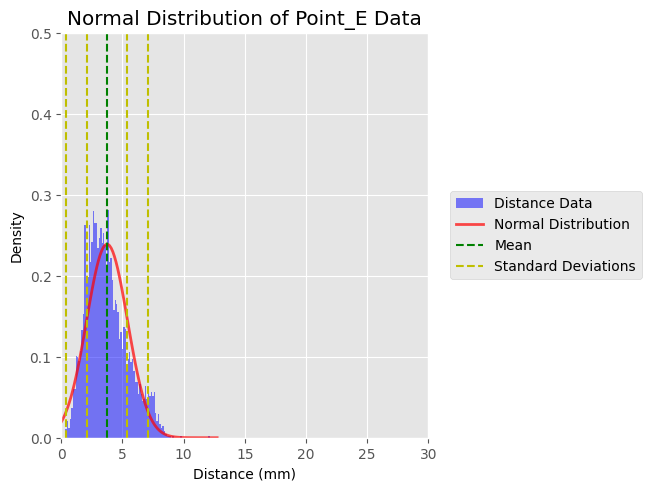

In [38]:
stdFig = plot_technique_std(
    distances,  # type: ignore
    graphStandards,
    eval,
    bins=100,
    hist_color='b', curve_color='r', 
    hist_alpha=0.5, curve_alpha=0.7,
    mean_color='g', std_color='y',
    x_lim_multiple=2, y_lim_multiple=0.1
)

stdFig.show()

In [39]:
stdFig.savefig(f'../data/{eval}-std-diagram.png', format='png', dpi=300)